<a href="https://colab.research.google.com/github/DavideMugi/ProgettoMachineLearning/blob/master/CAMS_T3D_BC_T1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the Type-1 Diabetes simulator (**remember to restart the runtime at the end of the installation!**):

In [ ]:
!pip install simglucose


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.1/600.1 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.8/157.8 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 858.3/858.3 kB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

A function that is needed to get the patient specific parameters:

In [ ]:
import pandas as pd
import pkg_resources


QUEST_PARA_FILE = pkg_resources.resource_filename(
    'simglucose', 'params/Quest.csv')
SENSOR_PARA_FILE = pkg_resources.resource_filename(
    'simglucose', 'params/sensor_params.csv')
VPATIENT_PARA_FILE = pkg_resources.resource_filename(
    'simglucose', 'params/vpatient_params.csv')
PUMP_PARA_FILE = pkg_resources.resource_filename(
    'simglucose', 'params/pump_params.csv')


def get_parameters(PARA_FILE, my_name, my_parameters):
  params = pd.read_csv(PARA_FILE)
  for i in range(params.shape[0]):
    if params.loc[i, 'Name'] == my_name:
      row_label = i
  my_parameters_list = []
  for my_parameter in my_parameters:
    my_parameters_list.append(params.loc[row_label, my_parameter])
  return my_parameters_list


Class that is used to transform raw data from the Simglucose environment to a state defined by me:

In [ ]:
import numpy as np

class StateTransformation:
  def __init__(self, past_bg, N):
    self.N = N
    self.past_bg = past_bg
    self.bg_states = np.zeros(self.past_bg+1)

    self.bg = []
    self.pre_basal = []
    self.pre_bolus = []
    self.pre_meal = []

  def convert(self, bg, pre_insulin, pre_meal):

    self.pre_basal.append(pre_insulin[0])
    self.pre_bolus.append(pre_insulin[1])
    self.pre_meal.append(pre_meal)

    if len(self.pre_basal) > self.N+1:
      self.pre_basal.pop(0)
      self.pre_bolus.pop(0)
      self.pre_meal.pop(0)


    insulin_activity_states = 0
    CHO_activity_states = 0
    for i in range(len(self.pre_basal)):
      insulin_activity_states += (1-(len(self.pre_basal)-(i+1))/(self.N+1)) * (self.pre_basal[i]+self.pre_bolus[i])
      CHO_activity_states += (1-(len(self.pre_basal)-(i+1))/(self.N+1)) * self.pre_meal[i]

    self.bg.append(bg)
    if len(self.bg) > self.past_bg*10+1:
      self.bg.pop(0)

    for i in range(len(self.bg)):
      if ((len(self.bg)-1)-i) % 10 == 0:
        self.bg_states[int(((len(self.bg)-1)-i) / 10)] = self.bg[i]
        #bg[0] corresponds to the current bg level, bg[1] // to 10 steps before bg level, and so on so forth

    state = np.append(self.bg_states, insulin_activity_states)
    state = np.append(state, CHO_activity_states)

    return state


Function that calculates the risk, trough the Magni risk function, of being in a certain blood glucose level:

In [ ]:
import math

def calculate_risk(bg, done):
  if not done:
    return 10 * math.pow((3.5506 * (math.pow(math.log(max(1, bg)), 0.8353) - 3.7932)), 2)
  else:
    return 1e5


Class needed to fill the experience replay from the expert algorithm, the PID:

In [ ]:
class ExpertReplay:
  def __init__(self, mem_size, prev_bg, N):
    self.mem_size = mem_size
    self.mem_cntr = 0
    self.prev_bg = prev_bg
    self.N = N

    self.state_transformation = StateTransformation(self.prev_bg, self.N)
    self.next_state_transformation = StateTransformation(self.prev_bg, self.N)

    self.states = np.zeros((self.mem_size, self.prev_bg+1+2))

    self.next_states = np.zeros((self.mem_size, self.prev_bg+1+2))

    self.rewards = np.zeros(self.mem_size)

    self.actions = np.zeros(self.mem_size)

    self.dones = np.zeros(self.mem_size)

  def fill(self, bg, pre_insulin, pre_meal, reward, done, next_bg, insulin, meal):
    if self.mem_cntr > self.mem_size:
      print('Maximum memory reached')
    else:

      self.states[self.mem_cntr] = self.state_transformation.convert(bg, pre_insulin, pre_meal)
      self.next_states[self.mem_cntr] = self.next_state_transformation.convert(next_bg, insulin, meal)


      self.actions[self.mem_cntr] = insulin[0]

      self.rewards[self.mem_cntr] = reward

      self.dones[self.mem_cntr] = done

      self.mem_cntr += 1

  def reset(self):
    self.state_transformation = StateTransformation(self.prev_bg, self.N)
    self.next_state_transformation = StateTransformation(self.prev_bg, self.N)


The implementation of the controller used for collecting the experience that will be fed to the offline RL algorithm, PID controller for basal insulin selection and an algorithm that provides standard bolus doses:

In [ ]:
from simglucose.controller.base import Controller, Action


class PID_N_BolusController(Controller):
    def __init__(self, P, I, D, patient_name, sensor_name, target=144, noise=False, bolus_noise=False):
        self.P = P
        self.I = I
        self.D = D
        self.target = target
        self.patient_name = patient_name
        self.sensor_name = sensor_name
        self.integrated_state = 0
        self.previous_error = 0
        self.noise = noise
        self.bolus_noise = bolus_noise
        if self.noise:
          self.prev_ou_noise = 0
          self.sigma = 0.2
          self.theta = 0.0015
          self.dt = 0.9

        Quest_parameters = get_parameters(QUEST_PARA_FILE, self.patient_name, ['TDI'])
        vpatient_parameters = get_parameters(VPATIENT_PARA_FILE, self.patient_name, ['BW', 'u2ss'])
        sensor_parameters = get_parameters(SENSOR_PARA_FILE, self.sensor_name, ['sample_time'])
        self.TDI = Quest_parameters[0]
        self.BW, self.u2ss = vpatient_parameters[0], vpatient_parameters[1]
        self.sample_time = sensor_parameters[0]

        self.basal_default = self.u2ss * (self.BW / 6000) * self.sample_time
        self.carbohydrate_ratio = 500 / self.TDI
        self.correction_factor = 1800 / self.TDI
        self.meal_history = np.zeros(int(3 * 60 / self.sample_time))

        self.expert_replay = ExpertReplay(100_000, 8, 10)

    def policy(self, observation, reward, done, **kwargs):
        meal = kwargs.get('meal')

        # current blood glucose
        bg = observation.CGM

        # proportional control
        error = self.target-bg
        p_act = self.P * error

        # integral control
        self.integrated_state += error
        i_act = self.I * self.integrated_state

        # derivative control
        d_act = self.D * (error - self.previous_error)
        self.previous_error = error

        basal = p_act + i_act + d_act + self.basal_default

        basal_rate = basal/ self.sample_time

        if self.noise:
          ou_noise = (self.prev_ou_noise + self.theta * (0 - self.prev_ou_noise) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=(1,))[0])
          ou_noise = ou_noise * self.basal_default
          self.prev_ou_noise = ou_noise
          basal_rate += ou_noise

        # save the adjusted meal
        adjusted_meal = meal

        # add some calculation error in bolus
        if self.bolus_noise:
            adjusted_meal += self.bolus_noise * adjusted_meal * np.random.uniform(-1, 1, 1)[0]

        bolus = adjusted_meal * self.sample_time / self.carbohydrate_ratio # correction (?) to the original code. The meal needs to be multiplied by the sample time cause the meal provided by info or kwargs is in g/min and after you are already diviiding by sample time!

        # if a meal hasn't occurred in meal history
        if np.sum(self.meal_history) == 0:

          # correct the bolus for high or low blood glucose
          bolus += (bg - self.target) / self.correction_factor

        bolus_rate = bolus / self.sample_time

        # update the meal history
        self.meal_history = np.append(self.meal_history, meal) #the real meal is being added to the history, it's just being used as a check to see if the patient has eaten once
        self.meal_history = np.delete(self.meal_history, 0)

        # return the action
        action = Action(basal=basal_rate, bolus=bolus_rate)
        return action

    def reset(self):
        self.integrated_state = 0
        self.previous_error = 0
        self.meal_history = np.zeros(int(3 * 60 / self.sample_time))
        if self.noise:
          self.prev_ou_noise = 0
        self.expert_replay.reset()
        action = Action(basal=self.basal_default/self.sample_time, bolus=0)
        return action


Simulation specifications:

In [ ]:
from datetime import datetime, timedelta

# specify start_time as the beginning of today, or change it manually to change the start time
now = datetime.now()
my_start_time = datetime.combine(now.date(), datetime.min.time())
my_sim_time=timedelta(days=10)
my_pump='Insulet'
my_patient = 'adult#001'
my_sensor = 'Dexcom'


Meal scenario definition:

In [ ]:
from simglucose.simulation.scenario import CustomScenario

deterministic = True
fasting = False

if deterministic:
  if not fasting:
    # deterministic meal scenario by me
    meal_scenario=[]
    for k in range(my_sim_time.days):
      if 11+24*k < my_sim_time.total_seconds()/3600:
          CHO = 45 # the actual grams
          time = 9+24*k
          meal_scenario.append((time, CHO))
      if 16+24*k < my_sim_time.total_seconds()/3600:
          CHO = 85
          time=14.5+24*k
          meal_scenario.append((time, CHO))
      if 22+24*k < my_sim_time.total_seconds()/3600:
          CHO = 90
          time = 21+24*k
          meal_scenario.append((time, CHO))
      if 24+24*k < my_sim_time.total_seconds()/3600:
          CHO = 30
          time = 23+24*k
          meal_scenario.append((time, CHO))
  else:
    meal_scenario = []
else:
  # stochastic meal scenario by Elena Daskalaki
  meal_scenario=[]
  for k in range(my_sim_time.days):
    if 11+24*k < my_sim_time.total_seconds()/3600:
        CHO = np.random.uniform(30, 60)
        time = np.random.uniform(7+24*k, 11+24*k)
        meal_scenario.append((time, CHO))
    if 16+24*k < my_sim_time.total_seconds()/3600:
        CHO = np.random.uniform(70, 100)
        time=np.random.uniform(13+24*k, 16+24*k)
        meal_scenario.append((time, CHO))
    if 22+24*k < my_sim_time.total_seconds()/3600:
        CHO = np.random.uniform(70, 110)
        time = np.random.uniform(20+24*k, 22+24*k)
        meal_scenario.append((time, CHO))
    if 24+24*k < my_sim_time.total_seconds()/3600:
        CHO = np.random.uniform(20, 40)
        time = np.random.uniform(23+24*k, 24+24*k)
        meal_scenario.append((time, CHO))

my_scenario = CustomScenario(start_time=my_start_time, scenario=meal_scenario)


Just a run of the fine tuned PID controller and standard bolus doses provider to show how it actually performs:

/usr/local/lib/python3.10/dist-packages/simglucose/patient/t1dpatient.py:272: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._last_Qsto = self.init_state[0] + self.init_state[1]
/usr/local/lib/python3.10/dist-packages/simglucose/patient/t1dpatient.py:272: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._last_Qsto = self.init_state[0] + self.init_state[1]


Process ID: 890
Simulation starts ...
Simulation Completed!
Simulation took 52.38000249862671 sec.


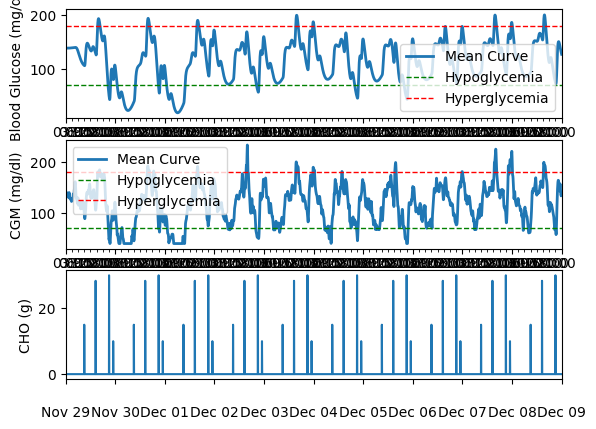

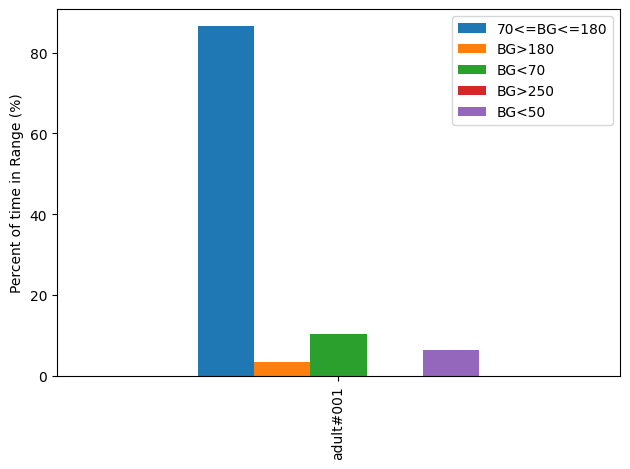

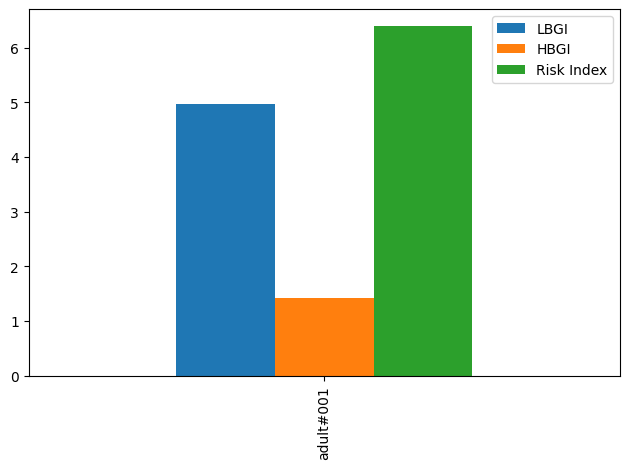

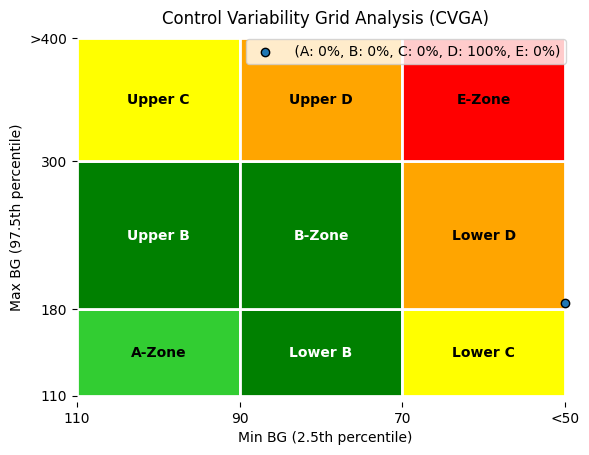

,70<=BG<=180,BG>180,BG<70,BG>250,BG<50,LBGI,HBGI,Risk Index
adult#001,86.461154,3.332639,10.206207,0.0,6.41533,4.976202,1.412661,6.388863


In [ ]:
from simglucose.simulation.user_interface import simulate


my_controller = PID_N_BolusController(P=-1.00E-04, I=-1.00E-07, D=-1.00E-02,
                                      patient_name=my_patient,
                                      sensor_name=my_sensor, target=144,
                                      noise=True, bolus_noise=0.1)

simulate(sim_time=my_sim_time,
         scenario=my_scenario,
         controller=my_controller,
         start_time=my_start_time,
         save_path='/content/results/PID4T1D',
         animate=False,
         parallel=False,
         patient_names=[my_patient], #use comma if multiples
         cgm_name=my_sensor,
         cgm_seed=41,
         insulin_pump_name=my_pump)


Now, let's collect the data for the offline RL algorithm:

In [ ]:
from simglucose.simulation.env import T1DSimEnv
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient


# Create a simulation environment
my_patient_sim = T1DPatient.withName(my_patient)
my_sensor_sim = CGMSensor.withName(my_sensor, seed=1)
my_pump_sim = InsulinPump.withName(my_pump)

env = T1DSimEnv(my_patient_sim, my_sensor_sim, my_pump_sim, my_scenario)

# consider that: done = BG < 10 or BG > 600

while my_controller.expert_replay.mem_cntr < my_controller.expert_replay.mem_size:
  pre_meal = 0
  pre_insulin = my_controller.reset()
  obs, _, done, info = env.reset()
  bg = obs.CGM
  while (env.time < env.scenario.start_time + my_sim_time) and (not done) and (my_controller.expert_replay.mem_cntr < my_controller.expert_replay.mem_size):
      meal = info['meal'] # the meal given by info is in units of g/min, so CHO/sample_time
      insulin = my_controller.policy(obs, _, done, **info)
      next_obs, _, done, next_info = env.step(insulin)
      next_bg = next_obs.CGM

      reward = - calculate_risk(next_bg, done)

      my_controller.expert_replay.fill(bg, pre_insulin, pre_meal, reward, done, next_bg, insulin, meal)

      pre_insulin = insulin
      pre_meal = meal
      obs = next_obs
      bg = next_bg
      info = next_info


Save the replay obtained:

In [ ]:
state_replay = my_controller.expert_replay.states

next_state_replay = my_controller.expert_replay.next_states

action_replay = my_controller.expert_replay.actions

reward_replay = my_controller.expert_replay.rewards

done_replay = my_controller.expert_replay.dones

np.savez('/content/replay.npz', state_replay=state_replay, next_state_replay=next_state_replay,
         action_replay=action_replay, reward_replay=reward_replay, done_replay=done_replay)


Now, just some standard checks to see if and what GPU is being used:

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


/bin/bash: line 1: nvidia-smi: command not found


The **actual TD3-BC algorithm implementation** in Tensorflow starts here:

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.14.0


In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers


class CriticNetwork(keras.Model):
    def __init__(self, action_dim, state_dim, fc1_dims=400, fc2_dims=300):
        super(CriticNetwork, self).__init__()
        self.action_dim = action_dim
        self.state_dim = state_dim
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        f1 = self.state_dim
        f2 = self.fc1_dims + self.action_dim

        self.fc1 = Dense(units=self.fc1_dims, kernel_initializer=initializers.RandomUniform(minval=-1/np.sqrt(f1),
                         maxval=1/np.sqrt(f1)), bias_initializer=initializers.RandomUniform(minval=-1/np.sqrt(f1),
                         maxval=1/np.sqrt(f1)), activation='relu')
        self.fc2 = Dense(units=self.fc2_dims, kernel_initializer=initializers.RandomUniform(minval=-1/np.sqrt(f2),
                         maxval=1/np.sqrt(f2)), bias_initializer=initializers.RandomUniform(minval=-1/np.sqrt(f2),
                         maxval=1/np.sqrt(f2)), activation='relu')
        self.q = Dense(1, kernel_initializer=initializers.RandomUniform(minval=-3e-3, maxval=3e-3),
                       bias_initializer=initializers.RandomUniform(minval=-3e-3, maxval=3e-3), activation=None)

    def call(self, inputs):
        state, action = inputs
        x = tf.concat([state, action], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.q(x)
        return q

    def get_config(self):
        config = super().get_config()
        return config


class ActorNetwork(keras.Model):
    def __init__(self, action_dim, state_dim, fc1_dims=400, fc2_dims=300):
        super(ActorNetwork, self).__init__()
        self.action_dim = action_dim
        self.state_dim = state_dim
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        f1 = self.state_dim  # added self f1 and f2
        f2 = self.fc1_dims

        self.fc1 = Dense(units=self.fc1_dims, kernel_initializer=initializers.RandomUniform(minval=-1/np.sqrt(f1),
                                                                                            maxval=1/np.sqrt(f1)),
                         bias_initializer=initializers.RandomUniform(minval=-1 / np.sqrt(f1),
                                                                     maxval=1 / np.sqrt(f1)), activation='relu')
        self.fc2 = Dense(units=self.fc2_dims, kernel_initializer=initializers.RandomUniform(minval=-1/np.sqrt(f2),
                                                                                            maxval=1/np.sqrt(f2)),
                         bias_initializer=initializers.RandomUniform(minval=-1/np.sqrt(f2),
                                                                     maxval=1/np.sqrt(f2)), activation='relu')
        self.mu = Dense(units=self.action_dim, kernel_initializer=initializers.RandomUniform(minval=-3e-3, maxval=3e-3),
                        bias_initializer=initializers.RandomUniform(minval=-3e-3, maxval=3e-3), activation='tanh')

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        mu = self.mu(x)
        return mu

    def get_config(self):
        config = super().get_config()
        return config


In [ ]:
class ReplayBuffer:
    def __init__(self, max_size, state_dim, action_dim):  # input shape of observation from our environment
        # action_dim --> It's the number of components of the action.
        self.mem_size = max_size
        self.mem_cntr = 0  # it's a memory counter, initiated to zero
        self.state_memory = np.zeros((self.mem_size, state_dim))  # the star * just unpack a list of elements
        self.new_state_memory = np.zeros((self.mem_size, state_dim))
        self.action_memory = np.zeros((self.mem_size, action_dim))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)  # we're going to use it as a mask later on
        # in the agent class

    def store_transition(self, state, action, reward, next_state, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = next_state
        self.terminal_memory[index] = done

        self.mem_cntr += 1
        if self.mem_cntr == self.mem_size:
            print('Replay buffer filled up for the first time.')

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        next_states = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, next_states, dones


In [ ]:
from tensorflow.keras.optimizers import Adam


class Agent:
    def __init__(self, state_dim, action_dim, max_action, min_action, alr=1e-3, clr=1e-3, gamma=0.99, max_size=100_000, tau=5e-3, d=2,
                 explore_sigma=0.1, smooth_sigma=0.2, c=0.5, alpha=2.5, fc1_dims=400, fc2_dims=300, batch_size=100, warmup=1000,
                 chkpt_dir='models/ddpg/'):
        self.action_dim = action_dim
        self.gamma = gamma
        self.d = d  # delay of the actor and target updates
        self.tau = tau
        self.explore_sigma = explore_sigma
        self.smooth_sigma = smooth_sigma
        self.c = c  # clip value of the noise added to smooth the action value estimate
        self.memory = ReplayBuffer(max_size, state_dim, action_dim)
        self.batch_size = batch_size
        self.max_action = max_action
        self.min_action = min_action
        self.chkpt_dir = chkpt_dir
        self.learn_step_cntr = 0
        self.time_step = 0
        self.warmup = warmup
        self.alpha = alpha

        self.actor = ActorNetwork(action_dim=action_dim, state_dim=state_dim, fc1_dims=fc1_dims,
                                  fc2_dims=fc2_dims)
        self.critic_1 = CriticNetwork(action_dim=action_dim, state_dim=state_dim, fc1_dims=fc1_dims,
                                      fc2_dims=fc2_dims)
        self.critic_2 = CriticNetwork(action_dim=action_dim, state_dim=state_dim, fc1_dims=fc1_dims,
                                      fc2_dims=fc2_dims)
        self.target_actor = ActorNetwork(action_dim=action_dim, state_dim=state_dim, fc1_dims=fc1_dims,
                                         fc2_dims=fc2_dims)
        self.target_critic_1 = CriticNetwork(action_dim=action_dim, state_dim=state_dim, fc1_dims=fc1_dims,
                                             fc2_dims=fc2_dims)
        self.target_critic_2 = CriticNetwork(action_dim=action_dim, state_dim=state_dim, fc1_dims=fc1_dims,
                                             fc2_dims=fc2_dims)

        self.actor.compile(optimizer=Adam(learning_rate=alr))
        self.critic_1.compile(optimizer=Adam(learning_rate=clr))
        self.critic_2.compile(optimizer=Adam(learning_rate=clr))
        self.target_actor.compile(optimizer=Adam(learning_rate=alr))
        self.target_critic_1.compile(optimizer=Adam(learning_rate=clr))
        self.target_critic_2.compile(optimizer=Adam(learning_rate=clr))

    def save_models(self):
        if (self.memory.mem_cntr < self.batch_size) or (self.time_step < self.warmup):
            # agent doesn't go into learning, no need to save the parameters (and it's not possible regardless until
            # the agent goes into learning which happens when buffer has a least one possible batch). And there's no
            # need to save the model if we're still in the warmup phase.
            return False
        else:
            print('... saving models ...')
            self.actor.save(self.chkpt_dir+'actor')
            self.target_actor.save(self.chkpt_dir+'target_actor')
            self.critic_1.save(self.chkpt_dir+'critic_1')
            self.critic_2.save(self.chkpt_dir + 'critic_2')
            self.target_critic_1.save(self.chkpt_dir+'target_critic_1')
            self.target_critic_2.save(self.chkpt_dir + 'target_critic_2')
            return True

    def load_models(self):
        print('... loading models ...')
        self.actor = keras.models.load_model(self.chkpt_dir+'actor')
        self.target_actor = keras.models.load_model(self.chkpt_dir+'target_actor')
        self.critic_1 = keras.models.load_model(self.chkpt_dir+'critic_1')
        self.critic_2 = keras.models.load_model(self.chkpt_dir + 'critic_2')
        self.target_critic_1 = keras.models.load_model(self.chkpt_dir+'target_critic_1')
        self.target_critic_2 = keras.models.load_model(self.chkpt_dir + 'target_critic_2')

    def collect_transition(self, state, action, reward, next_state, done):
        self.memory.store_transition(state, action, reward, next_state, done)

    def choose_action(self, observation, evaluate=False):
        if evaluate:
            state = tf.convert_to_tensor([observation], dtype=tf.float32)
            mu = self.actor(state)[0]
        else:
            if self.time_step == self.warmup:
                print('Warmup ended')
            if self.time_step < self.warmup:
                mu = tf.random.normal(shape=[self.action_dim], mean=0.0, stddev=self.explore_sigma)
            else:
                state = tf.convert_to_tensor([observation], dtype=tf.float32)
                # the action given by the actor is a tensor like [[value_1, value_2]], while the others
                # like [value_1, value_2], I don't know why.
                mu = self.actor(state)[0] + tf.random.normal(shape=[self.action_dim], mean=0.0,
                                                             stddev=self.explore_sigma)
            self.time_step += 1
        mu = tf.clip_by_value(mu, self.min_action, self.max_action)
        return mu

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic_1.weights
        for i, weight in enumerate(self.critic_1.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_critic_1.set_weights(weights)

        weights = []
        targets = self.target_critic_2.weights
        for i, weight in enumerate(self.critic_2.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.target_critic_2.set_weights(weights)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample_buffer(self.batch_size)

        states = tf.convert_to_tensor(states, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)

        with tf.GradientTape(persistent=True) as tape:
            target_actions = self.target_actor(next_states)
            epsilons = tf.clip_by_value(tf.random.normal(shape=[self.batch_size, self.action_dim], mean=0.0,
                                                         stddev=self.smooth_sigma), -self.c, self.c)
            smooth_actions = target_actions + epsilons

            next_critic_1_value = tf.squeeze(self.target_critic_1((next_states, smooth_actions)), 1)
            next_critic_2_value = tf.squeeze(self.target_critic_2((next_states, smooth_actions)), 1)
            critic_1_value = tf.squeeze(self.critic_1((states, actions)), 1)
            critic_2_value = tf.squeeze(self.critic_2((states, actions)), 1)
            target = rewards + self.gamma * tf.math.minimum(next_critic_1_value, next_critic_2_value) * (1 - dones)
            # in Tensorflow you can add two tensors
            # like this if they've the same shape and this results in an element-wise summation. Same principles apply
            # to the other simple math operations.
            critic_1_loss = keras.losses.MSE(target, critic_1_value)  # MSE between two tensors.
            critic_2_loss = keras.losses.MSE(target, critic_2_value)
        params_1 = self.critic_1.trainable_variables
        params_2 = self.critic_2.trainable_variables
        grads_1 = tape.gradient(critic_1_loss, params_1)
        grads_2 = tape.gradient(critic_2_loss, params_2)
        del tape
        self.critic_1.optimizer.apply_gradients(zip(grads_1, params_1))
        self.critic_2.optimizer.apply_gradients(zip(grads_2, params_2))

        self.learn_step_cntr += 1

        if self.learn_step_cntr % self.d == 0:
            with tf.GradientTape() as tape:
                new_policy_actions = self.actor(states)
                action_errors =  new_policy_actions - actions
                behavior_cloning_term = tf.math.reduce_sum((tf.math.square(action_errors)), axis=1)
                lamb = self.alpha/(tf.math.reduce_mean(tf.math.abs(self.critic_1((states, actions)))))
                actor_loss = - (lamb * self.critic_1((states, new_policy_actions))- behavior_cloning_term)
                actor_loss = tf.math.reduce_mean(actor_loss)  # computes the mean of a tensor more or less
            params = self.actor.trainable_variables
            grads = tape.gradient(actor_loss, params)
            self.actor.optimizer.apply_gradients(zip(grads, params))

            self.update_network_parameters()


Just a function that manages to use the least amount of GPU needed for deep learning:

In [ ]:
def manage_memory():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

Load the replay data collected by the expert agent:

In [ ]:
replay = np.load('/content/replay.npz')

state_replay = replay['state_replay']
next_state_replay = replay['next_state_replay']
action_replay = replay['action_replay']
reward_replay = replay['reward_replay']
done_replay = replay['done_replay']


In [ ]:
state_dim = state_replay.shape[1]
action_dim = 1


Z-score normalization of the state and action replay:

In [ ]:
def z_score_normalization(replay):
  normalized_replay = (replay - np.mean(replay, axis=0)) / np.std(replay, axis=0)
  mean = np.mean(replay, axis=0)
  std = np.std(replay, axis=0)
  return normalized_replay, mean, std

normalized_state_replay, mean_state_replay, std_state_replay = z_score_normalization(state_replay)
normalized_next_state_replay, _, _ = z_score_normalization(next_state_replay)
normalized_action_replay, mean_action_replay, std_action_replay = z_score_normalization(action_replay)

vpatient_parameters = get_parameters(VPATIENT_PARA_FILE, my_patient, ['BW', 'u2ss'])
BW, u2ss = vpatient_parameters[0], vpatient_parameters[1]

basal_default_rate = u2ss * (BW / 6000)

max_action = ((9 * basal_default_rate) - mean_action_replay) / std_action_replay
min_action = - max_action


Now, TD3-BC algorithm starts to **learn** from the collected data by the expert:

In [ ]:
manage_memory()
agent = Agent(state_dim=state_dim, action_dim=action_dim, max_action=max_action,
              min_action=min_action, alr=3e-4, clr=3e-4, max_size=100_000,
              batch_size = 256, fc1_dims=256, fc2_dims=256)


for i in range(100_000):
  agent.time_step += 1

  observation = normalized_state_replay[i]
  action = normalized_action_replay[i]
  reward = reward_replay[i]
  done = done_replay[i]
  next_observation = normalized_next_state_replay[i]

  agent.collect_transition(observation, action, reward, next_observation, done)
  agent.learn()
  if i % 1000 == 0 or i == 100_000-1:
    saved = agent.save_models()  # returns a boolean saying whether it has been saved or not
    print(f"Episode {i}. Is the model saved? {saved}.")

Save the final model in a directory:

In [ ]:
import shutil

folder_path = "/content/models"  # Replace with the actual path of your folder
shutil.make_archive("/content/models_download", 'zip', folder_path)

from google.colab import files

files.download("/content/models_download.zip")

Code that it's meant to load the model:

In [ ]:
import zipfile
import os

# Specify the path to the zip file in Colab
zip_file_path = '/content/models_download.zip'  # Change 'Your_Zip_File.zip' to the actual file name

# Specify the target directory for extraction in Colab
target_dir = '/content/models'  # Change 'Your_Target_Directory/' to the desired target directory

# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Extract the contents of the zip file into the target directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_dir)


The controller used to administer boluses and basal insulin doses coming from the TD3-BC control algorithm:

In [ ]:
class TD3_N_BolusController(Controller):
    def __init__(self, patient_name, sensor_name, past_bg, N, target=144, bolus_noise=False):

        self.N = N
        self.past_bg = past_bg
        self.state_transformation = StateTransformation(self.past_bg, self.N)
        self.bolus_noise = bolus_noise
        self.target = target


        Quest_parameters = get_parameters(QUEST_PARA_FILE, patient_name, ['TDI'])
        vpatient_parameters = get_parameters(VPATIENT_PARA_FILE, patient_name, ['BW', 'u2ss'])
        sensor_parameters = get_parameters(SENSOR_PARA_FILE, sensor_name, ['sample_time'])
        self.TDI = Quest_parameters[0]
        BW, u2ss = vpatient_parameters[0], vpatient_parameters[1]
        self.sample_time = sensor_parameters[0]

        self.basal_default = u2ss * (BW / 6000) * self.sample_time

        self.pre_insulin = [self.basal_default, 0]
        self.pre_meal = 0

        self.carbohydrate_ratio = 500 / self.TDI
        self.correction_factor = 1800 / self.TDI
        self.meal_history = np.zeros(int(3 * 60 / self.sample_time))

    def policy(self, observation, reward, done, **kwargs):
        meal = kwargs.get('meal')

        # current blood glucose
        bg = observation.CGM


        state = self.state_transformation.convert(bg, self.pre_insulin, self.pre_meal)
        basal_rate = select_action(state)


        # save the adjusted meal
        adjusted_meal = meal

        # add some calculation error in bolus
        if self.bolus_noise:
            adjusted_meal += self.bolus_noise * adjusted_meal * np.random.uniform(-1, 1, 1)[0]

        bolus = adjusted_meal * self.sample_time / self.carbohydrate_ratio # correction (?) to the original code. The meal needs to be multiplied by the sample time cause the meal provided by info or kwargs is in g/min and after you are already diviiding by sample time!

        # if a meal hasn't occurred in meal history
        if np.sum(self.meal_history) == 0:

          # correct the bolus for high or low blood glucose
          bolus += (bg - self.target) / self.correction_factor

        bolus_rate = bolus / self.sample_time

        # update the meal history
        self.meal_history = np.append(self.meal_history, meal) #the real meal is being added to the history, it's just being used as a check to see if the patient has eaten once
        self.meal_history = np.delete(self.meal_history, 0)

        self.pre_insulin = [basal_rate, bolus_rate]
        self.pre_meal = meal

        # return the action
        action = Action(basal=basal_rate, bolus=bolus_rate)
        return action

    def reset(self):
        self.meal_history = np.zeros(int(3 * 60 / self.sample_time))
        self.pre_insulin = [self.basal_default, 0]
        self.pre_meal = 0
        self.state_transformation = StateTransformation(self.past_bg, self.N)

Let's **test** the offline RL algorithm:

... loading models ...


/usr/local/lib/python3.10/dist-packages/simglucose/patient/t1dpatient.py:272: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._last_Qsto = self.init_state[0] + self.init_state[1]
/usr/local/lib/python3.10/dist-packages/simglucose/patient/t1dpatient.py:272: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._last_Qsto = self.init_state[0] + self.init_state[1]


Process ID: 18312
Simulation starts ...
Simulation Completed!
Simulation took 100.91753697395325 sec.


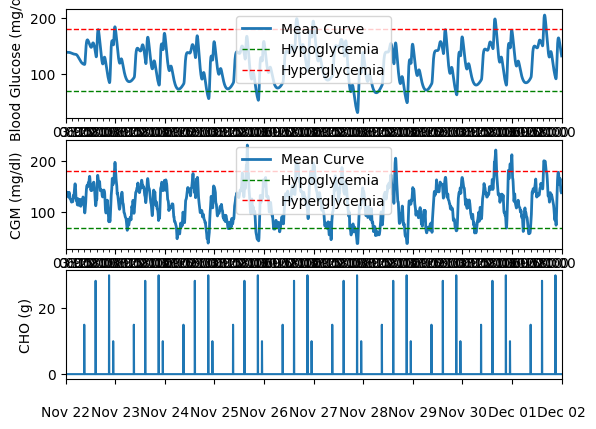

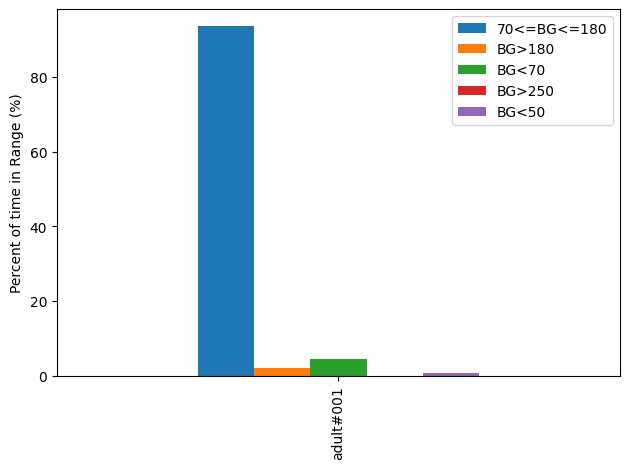

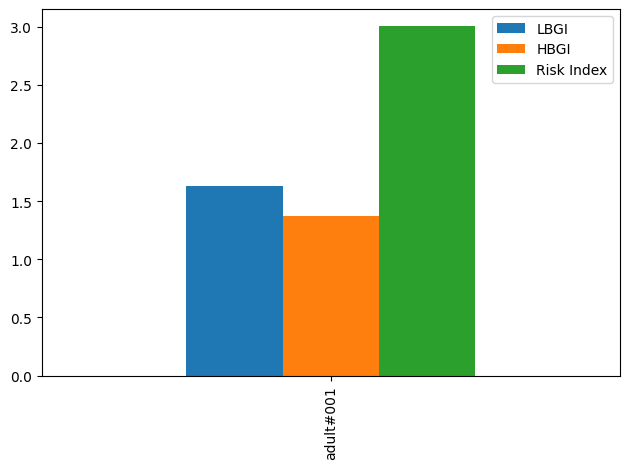

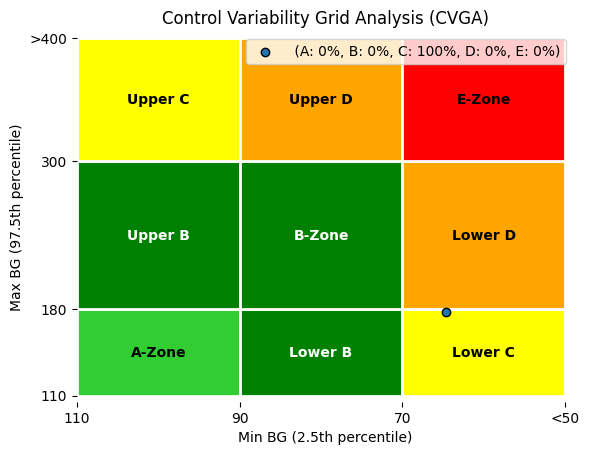

,70<=BG<=180,BG>180,BG<70,BG>250,BG<50,LBGI,HBGI,Risk Index
adult#001,93.522183,2.103728,4.374089,0.0,0.770673,1.630624,1.369953,3.000577


In [ ]:
agent = Agent(state_dim=state_dim, action_dim=action_dim, max_action=max_action,
            min_action=min_action, alr=3e-4, clr=3e-4, max_size=100_000,
            batch_size = 256, fc1_dims=256, fc2_dims=256)
agent.load_models()


def select_action(state):
  normalized_state = (state - mean_state_replay) / std_state_replay
  action = agent.choose_action(normalized_state, evaluate=True)
  action = action * std_action_replay + mean_action_replay
  agent.time_step += 1
  return action


my_controller = TD3_N_BolusController(my_patient, my_sensor, 8, 10, bolus_noise=0.1)

simulate(sim_time=my_sim_time,
         scenario=my_scenario,
         controller=my_controller,
         start_time=my_start_time,
         save_path='/content/results/TD3BC4T1D',
         animate=False,
         parallel=False,
         patient_names=[my_patient], #use comma if multiples
         cgm_name=my_sensor,
         cgm_seed=41, # 41 works, 40 very well (both)
         insulin_pump_name=my_pump)